In [1]:
from pymongo import MongoClient
import logging
from gensim.corpora import BleiCorpus
from gensim.models import LdaModel
from gensim import corpora
import os
import time
import multiprocessing
import sys
import string
import pickle
import pandas as pd
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from operator import itemgetter
from collections import Counter
from sklearn import metrics
from sklearn.feature_extraction import text
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import LSHForest
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import TruncatedSVD
% matplotlib inline

In [2]:
# connect to mongo client
client = MongoClient()
# connects to full collection of 2 million reviews
wine_info = client.wines.wine_info
# connects to collection of compacted wine names but still separated by year
c_wines = client.wines.consolidated_wines
# connect to collection of wine names with years stripped
no_year_wines = client.wines.stripped_year_wines

In [74]:
def consolidate_wines(dataframe):
    
    """
    Takes in a dataframe and groups by the wine name; creates lists containing the wine name, all of its reviews 
    concatenated into one string, the varietal, the year, and the average review points
    """
    
    review_text = []
    avg_review_points = []
    wine_name = []
    wine_varietal = []
    wine_year = []


    for wine, iterables in dataframe.groupby('wine/name'):

        # append wine name
        wine_name.append(wine)

        # combine all wine reviews in one string and append
        review_text.append(' '.join(iterables['review/text'].values))

        # append wine varietal
        wine_varietal.append(iterables['wine/variant'].values[0])

        # append wine year
        wine_year.append(iterables['wine/year'].values[0])

        # append average review score
        avg_review_points.append(np.nanmean(iterables['review/points'].values))   
        
    keys = ['wine/name', 'wine/variant', 'review/text', 'review/points', 'wine/year']
    individual_wines = zip(wine_name, wine_varietal, review_text, avg_review_points, wine_year)
        
    return [dict(zip(keys, wine)) for wine in individual_wines]

### Begin with all reviews

In [33]:
# pull all reviews in without id
all_reviews = wine_info.find({}, {'_id': 0})
print 'Total number of reviews: {0}'.format(all_reviews.count())

In [ ]:
all_reviews.alive

In [6]:
# create dataframe and replace 'N/A's in the review points column with NaN's in order to take averages on this column
all_df = pd.DataFrame(list(all_reviews))
all_df.replace({'review/points': {'N/A': np.nan}}, inplace=True)
all_df['review/points'] = all_df['review/points'].astype(float)

#### Consolidate multiple reviews per wine into one wine with one review string, and add into mongodb

In [66]:
# call function to get a list of wine dictionaries to send into mongo
#cons_wines = consolidate_wines(all_df)

In [ ]:
# create mongo collection to put wines
#consolidated_wines = client.wines.consolidated_wines
# loop through list and add wine to collection
#for wine in cons_wines:
#    consolidated_wines.save(wine)

### Work with consolidated wine names to strip off year and consolidate on pure name

In [ ]:
review_cursor = c_wines.find({}, {'_id': 0})
print 'Count of consolidated wines {0}'.format(review_cursor.count())

In [ ]:
review_cursor.alive

In [ ]:
# create dataframe of consolidated wines
cwine_df = pd.DataFrame(list(review_cursor))

#### Strip the dates from the wine and consolidate to just the wine brand name

In [ ]:
stripped_names = []

for wine_name in cwine_df['wine/name'].values:
    if wine_name[0] in ['1','2']:
        stripped_names.append(wine_name[4:].strip())
    else:
        stripped_names.append(wine_name)

cwine_df['wine/name'] = stripped_names

In [75]:
names_no_years = consolidate_wines(cwine_df)

In [76]:
len(names_no_years)

199278

In [77]:
# create mongo collection to put wines
#stripped_year_wines = client.wines.stripped_year_wines
# loop through list and add wine to collection
#for wine in names_no_years:
#    stripped_year_wines.save(wine)

### Use truncated SVD to find principal components / PCA

In [3]:
reviews = c_wines.find({}, {'_id': 0, 'review/text': 1})
print 'Count of consolidated reviews {0}'.format(reviews)

In [4]:
# create a list of all reviews to vectorize using tf-idf
reviews = [wine['review/text'] for wine in reviews]

In [6]:
# add additional stop words to filter out noise
additional_stop_words = ['wine', 'nose', 'br', 'years', 'time', 'hour', 'bottle']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

vectorizer = text.TfidfVectorizer(min_df=1, stop_words=stop_words, ngram_range=(1,2))
tfidf_reviews = vectorizer.fit_transform(reviews)
print 'Shape of resulting tf-idf vectors: {0}'.format(tfidf_reviews.shape)

#### SVD with n components

In [7]:
svd = TruncatedSVD(n_components=4)
X_reviews = svd.fit(tfidf_reviews).transform(tfidf_reviews)
print 'Shape of resulting principal components: {0}'.format(X_reviews.shape)

#### Find the 100 largest word(s) in the array to evaluate as principal components

In [30]:
max_ind = svd.components_[0].argsort()[-100:][::-1]
max_ind2 = svd.components_[1].argsort()[-100:][::-1]
max_ind3 = svd.components_[2].argsort()[-100:][::-1]
max_ind4 = svd.components_[3].argsort()[-100:][::-1]
#max_ind5 = svd.components_[4].argsort()[-100:][::-1]

In [26]:
# get feature names from the tf-idf vectorizer
feat_names = vectorizer.get_feature_names()

In [31]:
print 'Principal Component 1: '
print
print itemgetter(*max_ind)(feat_names)
print
print 'Principal Component 2: '
print itemgetter(*max_ind2)(feat_names)
print
print 'Principal Component 3: '
print itemgetter(*max_ind3)(feat_names)
print
print 'Principal Component 4: '
print itemgetter(*max_ind4)(feat_names)
#print
#print 'Principal Component 5: '
#print itemgetter(*max_ind5)(feat_names)

Principal Component 1: 

(u'fruit', u'good', u'finish', u'nice', u'palate', u'dark', u'red', u'medium', u'cherry', u'tannins', u'color', u'black', u'great', u'bit', u'acidity', u'oak', u'little', u'notes', u'light', u'long', u'spice', u'like', u'sweet', u'really', u'flavors', u'balanced', u'smooth', u'just', u'better', u'drink', u'bodied', u'fruits', u'ripe', u'quite', u'balance', u'rich', u'drinking', u'tart', u'taste', u'big', u'pepper', u'vanilla', u'earth', u'pinot', u'deep', u'mouth', u'body', u'aromas', u'cherries', u'price', u'hours', u'plum', u'red fruit', u'lots', u'blackberry', u'soft', u'excellent', u'hint', u'chocolate', u'long finish', u'berry', u'complex', u'slightly', u'decanted', u'ruby', u'glass', u'dry', u'opened', u'dark fruit', u'alcohol', u'purple', u'fresh', u'structure', u'touch', u'citrus', u'tasted', u'raspberry', u'medium bodied', u'bright', u'nicely', u'day', u'young', u'floral', u'cab', u'acid', u'lovely', u'food', u'green', u'leather', u'mineral', u'apple',

### K Means on Principal Components

#### Evaluate inertia to find best number of clusters

Running K 1...
Running K 2...
Running K 3...
Running K 4...
Running K 5...
Running K 6...
Running K 7...
Running K 8...
Running K 9...
Running K 10...
Running K 11...
Running K 12...
Running K 13...
Running K 14...
Running K 15...
Running K 16...
Running K 17...
Running K 18...
Running K 19...
Running K 20...
Running K 21...
Running K 22...
Running K 23...
Running K 24...
Running K 25...
Running K 26...
Running K 27...
Running K 28...
Running K 29...
Running K 30...
Running K 31...
Running K 32...
Running K 33...
Running K 34...
Running K 35...
Running K 36...
Running K 37...
Running K 38...
Running K 39...


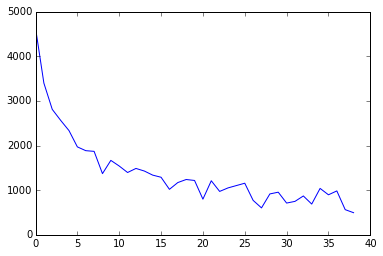

In [78]:
inertia_k = []

for num_cluster in range(1,40):
    print 'Running K {0}...'.format(num_cluster)
    km = MiniBatchKMeans(n_clusters = num_cluster)
    km.fit(X_reviews)
    inertia_k.append(km.inertia_)

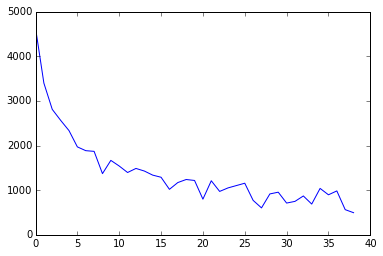

In [79]:
plt.plot(inertia_k)

#### Fit k-means using minibatch on best number of clusters

In [80]:
num_clusters = 40

km = MiniBatchKMeans(n_clusters = num_clusters)
km.fit(X_reviews)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=40,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

#### Loop through and print out each clusters centroid sentence, along with the variant, and the number of people who expressed similar views

In [81]:
clustered_sentences = sorted(zip(km.labels_, X_reviews, reviews), key=itemgetter(0))

for num_cluster in range(num_clusters):
    indiv_cluster = [clust_sent for clust_sent in clustered_sentences if clust_sent[0] == num_cluster]
    get_matrix = itemgetter(1) 
    cluster_vector = map(get_matrix, indiv_cluster)
    dist = [metrics.pairwise_distances(vector, km.cluster_centers_[num_cluster]) for vector in cluster_vector]
    min_dist = np.argmin(dist)
    variant = c_wines.find({'review/text': indiv_cluster[min_dist][2]}, {'_id': 0, 'wine/variant': 1})
    print 'Centroid {0}\'s Closest Sentence is \"{1}\"'.format(num_cluster + 1, indiv_cluster[min_dist][2].encode('ascii', 'ignore'))
    print 'Variant of wine: {0}'.format(str(variant.next()['wine/variant']))
    print '{0} number of people expressed a similar view'.format(len(cluster_vector))
    print

Centroid 1's Closest Sentence is "Little more green this time around. It's much better with food than on its own. Amazing value at $10. Beautiful fruit with a touch of minerality and chalkiness. This went amazingly well with pizza but also drank well on its own. This is exactly what I'm looking for in a $10 import. Over delivers in my opinion. This is a decent Portugese red that shows currant and blackberry aromas. The palate has smooth tannins and juicy black fruit. It's very easy to drink, just not that complex. But it's great for $12. Medicinal aromas of cherry cough syrup. Bright red raspberry flavors throughout. Fruit is a little candied and ripe. Better than most $10 wines. Tastes cheap. Second bottle in a row with consistent results. Heck of a bottle of wine, particularly for the money. Would jump on buying more if I can find it. - Brick color with slow forming legs with a full body. Round texture with a medium finish - Much better than expected. Drank over a two hour period of 

In [ ]:
#### Pick a particular cluster and print out all reviews for that cluster with its variant

In [10]:
clustered_reviews = zip(km.labels_, reviews)

for review in clustered_reviews:
    if review[0] == 1:
        print review[1]
        variant = c_wines.find({'review/text': review[1]}, {'_id': 0, 'wine/variant': 1})
        print 'Wine Variant: {0}'.format(str(variant.next()['wine/variant']))

Blandys most famous Solera EVER since it related to Napoleon. Final yield in 1957 was 1228 bottles. Lovely brown tinged amber color, rich meaty, tangy bouquet, still fairly sweet and full bodied, rich intense, yet soft on the palate with seemingly endless persistence of flavor. Dec 1983 - five stars! ***** &lt;M. Broadbent&gt; Celestial-historic and other worldly. the time machine of wines! better than sex
Wine Variant: White Blend
Medium tea colored brown with clear meniscus; plum and VA nose; good, rich, buttery, tart raisin palate with great acidity for a Malmsey; long finish (bottled in 1951)
Wine Variant: Malmsey, Malvazia
Rich, golden brown liquid; huge, sunny, lemony nose; rich, deep, layered flavors including coffee and caramel, laced with invigorating acid. On the two-minute finish, I sometimes picked up a tangy, smoky mélange of ripe oranges and orange rind. Wine hedonism doesn't get much better than this. 100+ pts. (The paper front label indicated that Blandy's Madeiras Ltd.

KeyboardInterrupt: 

### LSH - Locality Sensitive Hashing

In [ ]:
vectorizer2 = text.TfidfVectorizer(min_df=1, stop_words=stop_words, ngram_range=(1,2))
# Initialize a LSH forest and fit the vectorized reviews
lshf = LSHForest()
lshf.fit(X_reviews)
# Testing a group of reviews as one string from the main cellar dataset
#variable = .transform(['red full-bodied tannins smoky steak'])
#lshf.kneighbors(variable)

### Topic Modeling

In [43]:
tags_collection = client.wines.tags_collection

In [47]:
review_count = review_cursor.count()

In [98]:
def load_stopwords():
    more_stopwords = ['\'s', 'wine', 'nose', 'br', 'drink', 'year', 'time']
    stopwords = {}
    with open('stopwords.txt', 'rU') as f:
        for line in f:
            stopwords[line.strip()] = 1
        for char in string.punctuation:
            stopwords[char] = 1
    for more_words in more_stopwords:
        stopwords[more_words] = 1

    return stopwords


def worker(identifier, skip, count):
    done = 0
    start = time.time()

    stopwords = load_stopwords()

    batch_size = 100
    for batch in range(0, count, batch_size):
        reviews_cursor = c_wines.find().skip(skip + batch).limit(batch_size)
        for review in reviews_cursor:
            words = []
            sentences = nltk.sent_tokenize(review["review/text"].lower())

            for sentence in sentences:
                tokens = nltk.word_tokenize(sentence)
                text = [word for word in tokens if word not in stopwords]
                tagged_text = nltk.pos_tag(text)

                for word, tag in tagged_text:
                    words.append({"word": word, "pos": tag})

            tags_collection.insert({
                "wine/name": review["wine/name"],
                "wine/variant": review["wine/variant"],
                "review/points": review['review/points'],
                "review/text": review["review/text"],
                "words": words
            })

            done += 1
            if done % 100 == 0:
                end = time.time()
                print 'Worker' + str(identifier) + ': Done ' + str(done) + ' out of ' + str(count) + ' in ' + (
                    "%.2f" % (end - start)) + ' sec ~ ' + ("%.2f" % (done / (end - start))) + '/sec'
                sys.stdout.flush()
                
def main():
    reviews_cursor = c_wines.find()
    count = reviews_cursor.count()
    workers = 3
    batch = count / workers
    left = count % workers

    jobs = []
    for i in range(workers):
        size = count / workers
        if i == (workers - 1):
            size += left
        p = multiprocessing.Process(target=worker, args=((i + 1), i * batch, size))
        jobs.append(p)
        p.start()

    for j in jobs:
        j.join()
        print '%s.exitcode = %s' % (j.name, j.exitcode)

In [99]:
main()

Process-10.exitcode = 0
Process-11.exitcode = 0
Process-12.exitcode = 0
Worker2: Done 100 out of 159916 in 7.30 sec ~ 13.69/sec
Worker1: Done 100 out of 159916 in 8.81 sec ~ 11.35/sec
Worker3: Done 100 out of 159918 in 19.68 sec ~ 5.08/sec
Worker2: Done 200 out of 159916 in 29.57 sec ~ 6.76/sec
Worker1: Done 200 out of 159916 in 15.24 sec ~ 13.13/sec
Worker3: Done 200 out of 159918 in 28.40 sec ~ 7.04/sec
Worker2: Done 300 out of 159916 in 38.44 sec ~ 7.80/sec
Worker1: Done 300 out of 159916 in 22.96 sec ~ 13.07/sec
Worker3: Done 300 out of 159918 in 39.28 sec ~ 7.64/sec
Worker2: Done 400 out of 159916 in 50.99 sec ~ 7.84/sec
Worker1: Done 400 out of 159916 in 28.31 sec ~ 14.13/sec
Worker3: Done 400 out of 159918 in 47.57 sec ~ 8.41/sec
Worker2: Done 500 out of 159916 in 62.07 sec ~ 8.06/sec
Worker1: Done 500 out of 159916 in 34.84 sec ~ 14.35/sec
Worker3: Done 500 out of 159918 in 56.96 sec ~ 8.78/sec
Worker2: Done 600 out of 159916 in 79.57 sec ~ 7.54/sec
Worker1: Done 600 out of 159

In [100]:
corpus_collection = client.wines.corpus_collections

reviews_cursor = tags_collection.find()
reviewsCount = reviews_cursor.count()
reviews_cursor.batch_size(5000)

lem = WordNetLemmatizer()

done = 0
start = time.time()

for review in reviews_cursor:
    nouns = []
    words = [word for word in review["words"] if word["pos"] in ["NN"]]

    for word in words:
        nouns.append(lem.lemmatize(word["word"]))

    corpus_collection.insert({
        "wine/name": review["wine/name"],
        "wine/variant": review["wine/variant"],
        "review/points": review['review/points'],
        "review/text": review["review/text"],
        "words": nouns
    })

    done += 1
    if done % 100 == 0:
        end = time.time()
        os.system('cls')

Worker3: Done 8600 out of 159918 in 730.30 sec ~ 11.78/sec
Worker2: Done 8700 out of 159916 in 860.99 sec ~ 10.10/sec
Worker1: Done 8700 out of 159916 in 691.54 sec ~ 12.58/sec
Worker3: Done 8700 out of 159918 in 738.65 sec ~ 11.78/sec
Worker2: Done 8800 out of 159916 in 868.22 sec ~ 10.14/sec
Worker1: Done 8800 out of 159916 in 699.59 sec ~ 12.58/sec
Worker3: Done 8800 out of 159918 in 744.27 sec ~ 11.82/sec
Worker2: Done 8900 out of 159916 in 890.50 sec ~ 9.99/sec
Worker1: Done 8900 out of 159916 in 708.04 sec ~ 12.57/sec
Worker3: Done 8900 out of 159918 in 752.12 sec ~ 11.83/sec
Worker2: Done 9000 out of 159916 in 901.35 sec ~ 9.99/sec
Worker1: Done 9000 out of 159916 in 714.51 sec ~ 12.60/sec
Worker3: Done 9000 out of 159918 in 761.11 sec ~ 11.82/sec
Worker2: Done 9100 out of 159916 in 910.09 sec ~ 10.00/sec
Worker1: Done 9100 out of 159916 in 723.78 sec ~ 12.57/sec
Worker3: Done 9100 out of 159918 in 774.67 sec ~ 11.75/sec
Worker2: Done 9200 out of 159916 in 917.93 sec ~ 10.02/sec

In [101]:
class Corpus(object):
    def __init__(self, cursor, reviews_dictionary, corpus_path):
        self.cursor = cursor
        self.reviews_dictionary = reviews_dictionary
        self.corpus_path = corpus_path

    def __iter__(self):
        self.cursor.rewind()
        for review in self.cursor:
            yield self.reviews_dictionary.doc2bow(review["words"])

    def serialize(self):
        BleiCorpus.serialize(self.corpus_path, self, id2word=self.reviews_dictionary)

        return self


class Dictionary(object):
    def __init__(self, cursor, dictionary_path):
        self.cursor = cursor
        self.dictionary_path = dictionary_path

    def build(self):
        self.cursor.rewind()
        dictionary = corpora.Dictionary(review["words"] for review in self.cursor)
        dictionary.filter_extremes(keep_n=10000)
        dictionary.compactify()
        corpora.Dictionary.save(dictionary, self.dictionary_path)

        return dictionary


class Train:
    def __init__(self):
        pass

    @staticmethod
    def run(lda_model_path, corpus_path, num_topics, id2word):
        corpus = corpora.BleiCorpus(corpus_path)
        lda = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=id2word)
        lda.save(lda_model_path)

        return lda


def main():
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

    dictionary_path = "models/dictionary.dict"
    corpus_path = "models/corpus.lda-c"
    lda_num_topics = 50
    lda_model_path = "models/lda_model_50_topics.lda"

    reviews_cursor = corpus_collection.find()

    dictionary = Dictionary(reviews_cursor, dictionary_path).build()
    Corpus(reviews_cursor, dictionary, corpus_path).serialize()
    Train.run(lda_model_path, corpus_path, lda_num_topics, dictionary)

Worker2: Done 17200 out of 159916 in 1981.29 sec ~ 8.68/sec
Worker1: Done 17200 out of 159916 in 1657.71 sec ~ 10.38/sec
Worker3: Done 17200 out of 159918 in 1593.08 sec ~ 10.80/sec
Worker2: Done 17300 out of 159916 in 1992.66 sec ~ 8.68/sec
Worker1: Done 17300 out of 159916 in 1667.79 sec ~ 10.37/sec
Worker3: Done 17300 out of 159918 in 1603.21 sec ~ 10.79/sec
Worker2: Done 17400 out of 159916 in 2001.31 sec ~ 8.69/sec
Worker1: Done 17400 out of 159916 in 1678.04 sec ~ 10.37/sec
Worker3: Done 17400 out of 159918 in 1609.90 sec ~ 10.81/sec
Worker2: Done 17500 out of 159916 in 2015.60 sec ~ 8.68/sec
Worker1: Done 17500 out of 159916 in 1682.95 sec ~ 10.40/sec
Worker3: Done 17500 out of 159918 in 1617.45 sec ~ 10.82/sec
Worker2: Done 17600 out of 159916 in 2026.04 sec ~ 8.69/sec
Worker1: Done 17600 out of 159916 in 1688.55 sec ~ 10.42/sec
Worker3: Done 17600 out of 159918 in 1632.18 sec ~ 10.78/sec
Worker2: Done 17700 out of 159916 in 2046.94 sec ~ 8.65/sec
Worker1: Done 17700 out of 159

In [102]:
main()

Worker2: Done 25700 out of 159916 in 2933.49 sec ~ 8.76/sec
Worker1: Done 25700 out of 159916 in 2902.23 sec ~ 8.86/sec
Worker3: Done 25700 out of 159918 in 2632.49 sec ~ 9.76/sec
Worker2: Done 25800 out of 159916 in 2938.92 sec ~ 8.78/sec
Worker1: Done 25800 out of 159916 in 2912.06 sec ~ 8.86/sec
Worker3: Done 25800 out of 159918 in 2643.51 sec ~ 9.76/sec
Worker2: Done 25900 out of 159916 in 2945.24 sec ~ 8.79/sec
Worker1: Done 25900 out of 159916 in 2920.16 sec ~ 8.87/sec
Worker3: Done 25900 out of 159918 in 2648.86 sec ~ 9.78/sec
Worker2: Done 26000 out of 159916 in 2953.91 sec ~ 8.80/sec
Worker1: Done 26000 out of 159916 in 2934.42 sec ~ 8.86/sec
Worker3: Done 26000 out of 159918 in 2655.74 sec ~ 9.79/sec
Worker2: Done 26100 out of 159916 in 2964.58 sec ~ 8.80/sec
Worker1: Done 26100 out of 159916 in 2945.37 sec ~ 8.86/sec
Worker3: Done 26100 out of 159918 in 2663.08 sec ~ 9.80/sec
Worker2: Done 26200 out of 159916 in 2979.98 sec ~ 8.79/sec
Worker1: Done 26200 out of 159916 in 295

In [65]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

dictionary_path = "models/dictionary.dict"
corpus_path = "models/corpus.lda-c"
lda_num_topics = 50
lda_model_path = "models/lda_model_50_topics.lda"

dictionary = corpora.Dictionary.load(dictionary_path)
corpus = corpora.BleiCorpus(corpus_path)
lda = LdaModel.load(lda_model_path)

i = 0
for topic in lda.show_topics(num_topics=lda_num_topics):
    print '#' + str(i) + ': ' + topic
    i += 1

#0: 0.151*fine + 0.043*toast + 0.041*yeasty + 0.035*tiny + 0.029*toasty + 0.025*fizz + 0.024*mousse + 0.018*steel + 0.018*gentle + 0.015*persistent
#1: 0.112*pepper + 0.051*fruit + 0.039*rhone + 0.036*shiraz + 0.028*spice + 0.025*grenache + 0.024*syrah + 0.023*cdp + 0.019*black + 0.018*peppery
#2: 0.108*bottle + 0.057*glass + 0.047*drank + 0.042*day + 0.033*hour + 0.030*night + 0.028*bit + 0.021*couple + 0.020*winery + 0.019*dinner
#3: 0.038*cote + 0.034*start + 0.030*club + 0.022*linear + 0.022*event + 0.020*barossa + 0.020*drop + 0.018*fall + 0.018*rotie + 0.018*alot
#4: 0.081*fruit + 0.067*ripe + 0.043*tannin + 0.041*acidity + 0.035*dark + 0.033*palate + 0.026*structure + 0.026*firm + 0.024*bouquet + 0.023*lot
#5: 0.039*bread + 0.022*sipper + 0.022*roundness + 0.021*kistler + 0.021*watermelon + 0.017*ideal + 0.017*nectarine + 0.016*w/ + 0.015*ham + 0.014*gum
#6: 0.160*grape + 0.117*juice + 0.039*pink + 0.030*candy + 0.025*fruitiness + 0.021*gamay + 0.021*afternoon + 0.020*roast + 0.

In [ ]:
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from time import time
from matplotlib.ticker import NullFormatter

#Axes3D

tsne = manifold.TSNE(perplexity=40, n_components=2, verbose=2)
Y = tsne.fit_transform(X_reviews)
#ax = fig.add_subplot(250)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
#ax.xaxis.set_major_formatter(NullFormatter())
#ax.yaxis.set_major_formatter(NullFormatter())
#plt.axis('tight')
plt.show()

#### Query the database for reviews that contain steak related words

In [ ]:
steak_cursor = wine_info.find({ "$text" : { "$search": 'steak strip porterhouse ribeye mignon -tuna -salmon'}}, {'_id': 0})
print 'Steak Count: {0}'.format(steak_cursor.count())

#### Narrow down to reviews that include "pair" and "match" which are more likely to be pairing matches

In [ ]:
locate_words = ['pair', 'match']
steak_wines = []

for wine in steak_cursor:
    if any(word in wine['review/text'] for word in locate_words): # and 'well' in wine['review/text']:
        steak_wines.append(wine)
        
print 'Number of wines that potentially pair well with steak: {0}'.format(len(steak_wines))

#### Creates a list of wine names that are good with steak to query the database to get ALL reviews for each wine instead of just steak related

In [ ]:
steakdf = pd.DataFrame(steak_wines)

full_steak_list = []

for wine in steakdf['wine/name'].value_counts().index:
    full_steak_list.append({'wine/name': wine})
    
full_steak_cursor = wine_info.find({'$or': full_steak_list})
print 'Count of steak related wines: {0}'.format(full_steak_cursor.count())

In [ ]:
reds = ['Cabernet Sauvignon', 'Merlot', 'Cabernet Franc', 'Malbec', 'Syrah/Shiraz', 'Syrah', 'Red Blend', 'Grenache',
        'Mourvedre', 'Rhone Red Blend', 'Pinot Noir', 'Gamay', 'Zinfandel', 'Petite Sirah', 'Tempranillo', 'Nebbiolo',
        'Dolcetto', 'Nero d\'Avola', 'Primitivo', 'Barbera', 'Sangiovese', 'Carmenere', 'Pinotage', 'Red Bordeaux Blend']